In [ ]:
import numpy as np
import scipy.io
import os
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import signal
import IPython.display as ipd
from scipy.signal import argrelextrema



In [ ]:
folder_id = '1H79QlliVYFXPeo0oLh__3kQkMlZnABWG' # Enter the last part of the URL of the Google Drive folder here

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': '\'' + folder_id + "\' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)
  
os.chdir(local_download_path)

title: Special Peak.pdf, id: 1osj4zDWew6V-OGjynGaF8-mM1HuQc5vu
downloading to /root/data/Special Peak.pdf
title: ExpectedMean.csv, id: 1lfHwVFhsQX-gG6YCe8mDXYfUdn1QYjze
downloading to /root/data/ExpectedMean.csv
title: Signal.csv, id: 1zL_lAG20bnh2aHA-C-0Ez0FwIhqUgZRK
downloading to /root/data/Signal.csv


In [ ]:
signal_original = np.genfromtxt(open("Signal.csv","rb"),delimiter=",") # Port Original Data
signal_mean = np.genfromtxt(open("ExpectedMean.csv","rb"),delimiter=",") # Port Original Data


Text(0.5, 1.0, 'Original Signal')

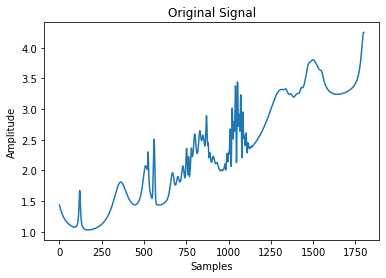

In [ ]:
plt.plot(signal_original)  # Plot Noisy Signal
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original Signal')

In [ ]:
signal_removed_linear_bias = signal.detrend(signal_original) # Removed Linear Bias from Noisy signal
#signal_removed_linear_bias = abs(signal_removed_linear_bias)

Signal Mean: 2.4855187314206723e-16


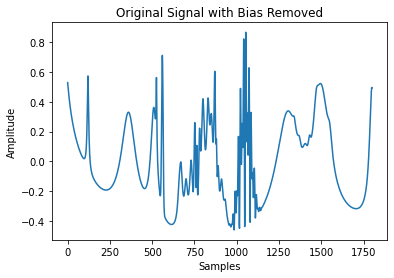

In [ ]:
plt.plot(signal_removed_linear_bias) # Plot Signal wih no bias
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original Signal with Bias Removed')

print('Signal Mean:',signal_removed_linear_bias.mean()) # Mean close to zero which means the trend is removed

In [ ]:
def special_peak_detector(input_signal,peaks,offset_time, sampling_frequency, valid_peaks,removed_peaks): 
  '''
    Recursive function to find the special peak of the input signal and it Returns the Special Peak, Valid Peaks and the Removed Peaks.

    Parameters:
        input_signal (numpy):Input signal from where the peaks are caculated
        offset_time (sec) : Maximum window search across unnamed peaks to check for neighbouring removed peaks
        sampling_frequency (Hz) : Signal sampled at a particular frequency (samples/sec)
        valid_peaks (list) : Empty list to recursively store the valid peaks
        removed_peaks (list) : Empty list to recursively store the removed peaks

    Returns:
        special_peak (int) : Detected Special Peak
        valid_peaks (list) : List of the valid peaks
        removed_peaks (list) : List of the removed peaks    
    
  '''

  if len(peaks)==0:   
    removed_flatten = [peak_element for sub_peak_array in removed_peaks for peak_element in sub_peak_array] #Flatten the List[list]
    special_peak =valid_peaks[np.argmin(input_signal[valid_peaks])] # Minimum amplitude across the valid peaks
    return special_peak,valid_peaks,removed_flatten
  else:
    peak_max = peaks[np.argmax(input_signal[peaks])] # Peak having the highest amplitude (An)

    window_check = np.arange(peak_max-offset_time*sampling_frequency,peak_max+offset_time*sampling_frequency+1) #Window to check if peaks exist within this bounds
    common_peaks = np.intersect1d(peaks,window_check) #Peaks found within the window ->[Valid Peak +- Removed Peak(s)]
    common_peaks = common_peaks[common_peaks!=peak_max]
    peaks_not_include=[]
    
    if len(common_peaks)>1: # There are more peaks than the Valid Peak->Removed Peaks
      removed_peak_cond = common_peaks[(np.where(input_signal[common_peaks]>(input_signal[peak_max]/2)))].tolist()
      removed_peaks.append(removed_peak_cond) # Remove those peaks with Amplitudes > An/2
      peaks_not_include = removed_peak_cond[:]
    
    peaks_not_include.append(peak_max)

    valid_peaks.append(peak_max) # Append the Valid Peak

    print('Peak Start of Step and Length:', peaks,len(peaks))
    print('Valid Peaks:', valid_peaks)
    print('Removed peaks: ', removed_peaks)
    print('Peaks not included: ', peaks_not_include)

    peaks = peaks[(~np.in1d(peaks,peaks_not_include))] # New list of Peaks don't include the current Valid Peaks and Removed Peak(s)
    print('Peak After Step and Length:', peaks,len(peaks))

    return special_peak_detector(input_signal,peaks,offset_time, sampling_frequency, valid_peaks,removed_peaks) # Recursively continue the process

In [ ]:
def zero_crossing_differential(input_signal): # Find peaks using zero crossing difference(derivative)-local maxima
  peaks = argrelextrema(input_signal, np.greater)[0] #There are edge cases where angrelextrma wouldn't work through
                                                      # unit-testing but for the sake of the 1-2 hour assignment it works.


  peaks=peaks.tolist()
  peaks.append(0)
  peaks = np.sort(peaks)

  print(peaks)

  peaks2 = scipy.signal.find_peaks(input_signal)

  print(peaks2)
  '''
  first_derivative = np.diff(input_signal)
  sign = np.sign(first_derivative)
  local_maxima = np.where(np.diff(sign)<0)[0] + 1
  '''

  return peaks


peaks = zero_crossing_differential(signal_removed_linear_bias)


[   0  120  360  509  525  560  669  700  730  752  764  780  800  830
  849  870  879  890  910  930  959  970  979  991 1001 1010 1022 1032
 1041 1053 1063 1072 1084 1093 1104 1116 1125 1135 1304 1336 1366 1405
 1432 1495 1799]
(array([ 120,  360,  509,  525,  560,  669,  700,  730,  752,  764,  780,
        800,  830,  849,  870,  879,  890,  910,  930,  959,  970,  979,
        991, 1001, 1010, 1022, 1032, 1041, 1053, 1063, 1072, 1084, 1093,
       1104, 1116, 1125, 1135, 1304, 1336, 1366, 1405, 1432, 1495, 1799]), {})


Text(0.5, 1.0, 'Original Signal with Bias Removed - Peaks detected by Zero Crossing')

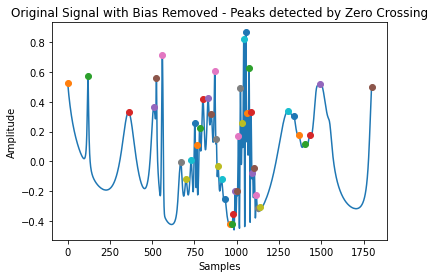

In [ ]:
plt.plot(signal_removed_linear_bias)
for peak in peaks:
  plt.plot(peak,signal_removed_linear_bias[peak],"o")
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original Signal with Bias Removed - Peaks detected by Zero Crossing')

In [ ]:
valid_peaks=[]
removed_peaks = []
offset_time = 5
sampling_frequency = 10
special_peak, valid_peaks,removed_peaks = \
special_peak_detector(signal_removed_linear_bias,peaks,offset_time, sampling_frequency, valid_peaks,removed_peaks)



Peak Start of Step and Length: [   0  120  360  509  525  560  669  700  730  752  764  780  800  830
  849  870  879  890  910  930  959  970  979  991 1001 1010 1022 1032
 1041 1053 1063 1072 1084 1093 1104 1116 1125 1135 1304 1336 1366 1405
 1432 1495 1799] 45
Valid Peaks: [1053]
Removed peaks:  [[1022, 1041, 1072]]
Peaks not included:  [1022, 1041, 1072, 1053]
Peak After Step and Length: [   0  120  360  509  525  560  669  700  730  752  764  780  800  830
  849  870  879  890  910  930  959  970  979  991 1001 1010 1032 1063
 1084 1093 1104 1116 1125 1135 1304 1336 1366 1405 1432 1495 1799] 41
Peak Start of Step and Length: [   0  120  360  509  525  560  669  700  730  752  764  780  800  830
  849  870  879  890  910  930  959  970  979  991 1001 1010 1032 1063
 1084 1093 1104 1116 1125 1135 1304 1336 1366 1405 1432 1495 1799] 41
Valid Peaks: [1053, 560]
Removed peaks:  [[1022, 1041, 1072]]
Peaks not included:  [560]
Peak After Step and Length: [   0  120  360  509  525  669  7

In [ ]:
print('FINAL RESULTS:')
print('Peaks: ',peaks)
print('Valid Peaks: ',valid_peaks)
print('Removed Peaks: ', removed_peaks)
print('Special Peak: ', special_peak)

FINAL RESULTS:
Peaks:  [   0  120  360  509  525  560  669  700  730  752  764  780  800  830
  849  870  879  890  910  930  959  970  979  991 1001 1010 1022 1032
 1041 1053 1063 1072 1084 1093 1104 1116 1125 1135 1304 1336 1366 1405
 1432 1495 1799]
Valid Peaks:  [1053, 560, 870, 120, 525, 0, 1495, 1799, 800, 509, 1304, 360, 1084, 1336, 1032, 1432, 1366, 879, 1405, 764, 730, 669, 890, 1104, 1093, 700, 910, 1001, 991, 1116, 930, 1135, 1125, 979, 959, 970]
Removed Peaks:  [1022, 1041, 1072, 830, 849, 752, 780, 1063, 1010]
Special Peak:  970


Text(0.5, 1.0, 'Original Signal with Bias Removed - Valid and Removed Peaks detected by Zero Crossing')

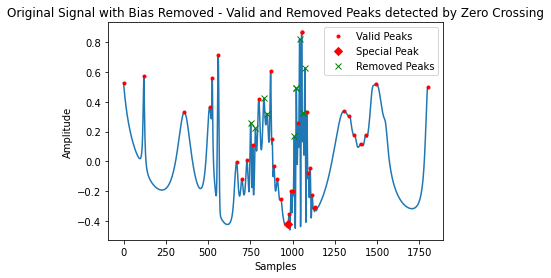

In [ ]:
plt.plot(signal_removed_linear_bias)
for count,valid_peak in enumerate(valid_peaks):
  plt.plot(valid_peak,signal_removed_linear_bias[valid_peak],'.', color='r')
  if count==0:
    plt.plot(valid_peak,signal_removed_linear_bias[valid_peak],".", color='r',label='Valid Peaks')
  if valid_peak==special_peak:
    plt.plot(valid_peak,signal_removed_linear_bias[valid_peak],"D", color='r',label='Special Peak')  
for count,removed_peak in enumerate(removed_peaks):
  plt.plot(removed_peak,signal_removed_linear_bias[removed_peak],'x', color='g')
  if count==0:
    plt.plot(removed_peak,signal_removed_linear_bias[removed_peak],'x', color='g',label='Removed Peaks')

plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('Original Signal with Bias Removed - Valid and Removed Peaks detected by Zero Crossing')